In [10]:
from pprint import pprint
import numpy as np
import scipy.sparse as spar
import re

## 70. データの入手・整形
文に関する極性分析の正解データを用い，以下の要領で正解データ（sentiment.txt）を作成せよ．

rt-polarity.posの各行の先頭に"+1 "という文字列を追加する（極性ラベル"+1"とスペースに続けて肯定的な文の内容が続く）
rt-polarity.negの各行の先頭に"-1 "という文字列を追加する（極性ラベル"-1"とスペースに続けて否定的な文の内容が続く）
上述1と2の内容を結合（concatenate）し，行をランダムに並び替える
sentiment.txtを作成したら，正例（肯定的な文）の数と負例（否定的な文）の数を確認せよ．

In [ ]:
from random import shuffle

overwrite = False

with open("rt-polaritydata/rt-polarity.neg" ,encoding='iso8859_2') as neg, open("rt-polaritydata/rt-polarity.pos", encoding='iso8859_2') as pos:
    plus1, minus1 = ["+1\t" + line for line in pos], ["-1\t" + line for line in neg]
    
data = plus1 + minus1
shuffle(data)

if overwrite:
    with open("data/sentiment.txt", 'w', encoding='utf-8') as f:
        f.write(''.join(data))

## 71. ストップワード

英語のストップワードのリスト（ストップリスト）を適当に作成せよ．さらに，引数に与えられた単語（文字列）がストップリストに含まれている場合は真，それ以外は偽を返す関数を実装せよ．さらに，その関数に対するテストを記述せよ．

### memo
[Ranks NL](https://www.ranks.nl/stopwords)よりstopwords.txtを作成

In [2]:
def is_stopword(string):
    with open("data/stopwords.txt", encoding='utf-8') as sw_file:
        stopwords = sw_file.read().split('\n')
        
    return string.lower() in stopwords

testcase = [('a', True), ('b', False), ('I', True), ('mine', False)]

for word, tf in testcase:
    assert is_stopword(word) == tf, "something went wrong with ''{}'' ".format(word)

## 72. 素性抽出

極性分析に有用そうな素性を各自で設計し，学習データから素性を抽出せよ．素性としては，レビューからストップワードを除去し，各単語をステミング処理したものが最低限のベースラインとなるであろう．

### memo
stemming -> tf-idfがよさそう

- 極性データ: polarity.npy(numpy)
- 素性ベクトル: features.npz(scipy.sparse)
- ラベル: label.txt


In [9]:
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import scipy.sparse as spar

def formatter(line):
    # 角括弧の除去
    l = re.sub(r'[\[\]]', '', line)
    # 不要な空白の除去
    l = re.sub(r" ([\W])(?=\s)", '\g<1>', l)
    # 改行の除去
    l = re.sub(' \n', '', l)
    # 極性と文章の分離
    sgn, sentence = l.split('\t')
    
    # 文書にstemmingをかける
    ps = PorterStemmer()
    corpus = ' '.join([ps.stem(word) for word in sentence.split() if not is_stopword(word)])
    return int(sgn), corpus

with open ("data/sentiment.txt", encoding='utf-8') as src:
    sc = [formatter(line) for line in src]
    sgns, corpuses = zip(*sc)
        
# sklearnに全部丸投げ
vectorizer = TfidfVectorizer()
res = vectorizer.fit_transform(corpuses)

# データの保存
np.save('data/polarity.npy', np.array(sgns, dtype='short'))
spar.save_npz('data/features.npz', res)
with open('data/label.txt', 'w') as f:
    f.write('\n'.join(vectorizer.get_feature_names()))

## 73. 学習
72で抽出した素性を用いて，ロジスティック回帰モデルを学習せよ．

### memo
sklearnに丸投げ
[documentation of LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [17]:
from sklearn.linear_model import LogisticRegression

features = spar.load_npz('data/features.npz')
porality = np.load('data/polarity.npy')

model = LogisticRegression(solver='lbfgs')
model.fit(features, porality)
print('finish learning')

finish learning


## 74. 予測
73で学習したロジスティック回帰モデルを用い，与えられた文の極性ラベル（正例なら"+1"，負例なら"-1"）と，その予測確率を計算するプログラムを実装せよ．

### memo
model.predict, model.predict_probaに素性データを丸投げ  
probabilityの第1項は極性が-1の確率、第2項は極性が1の確率

In [61]:
sentence_id = 1 # 0 <= x < 10662
feature = features[sentence_id]
predict = model.predict(feature)[0]
probability = model.predict_proba(feature)[0]

print('sentence id: {} -> polarity: {}\tprobability: {}'.format(sentence_id, predict, probability))


sentence id: 1 -> polarity: -1	probability: [0.70301472 0.29698528]


## 75. 素性の重み
73で学習したロジスティック回帰モデルの中で，重みの高い素性トップ10と，重みの低い素性トップ10を確認せよ．

In [53]:
coef = model.coef_[0]
idxs = np.argsort(-coef) # 降順ソート
label = np.loadtxt('data/label.txt', dtype=str)

check = False
if check:
    print('Good Words')
    for idx in np.nditer(idxs[:10]):
        print(label[idx], coef[idx])

    print('Bad Words')
    for idx in np.nditer(idxs[-10:]):
        print(label[idx], coef[idx])
    
with open('res/75.txt', 'w') as f:
    for idx in np.nditer(idxs):
        f.write('{}\t{:.5f}\n'.format(label[idx], coef[idx]))

## 76. ラベル付け
学習データに対してロジスティック回帰モデルを適用し，正解のラベル，予測されたラベル，予測確率をタブ区切り形式で出力せよ．

In [68]:
sentence_id = 1 # 0 <= x < 10662
features = spar.load_npz('data/features.npz')
porality = np.load('data/polarity.npy')
predict = model.predict(features)
probability = model.predict_proba(features)

with open('res/76.txt', 'w') as f:
    ## label
    f.write('polarity\tpredict\tP(s=-1)\tP(s=1)\n')
    for idx in range(len(porality)):
        f.write('{}\t{}\t{:.5f}\t{:.5f}\n'.format(porality[idx], predict[idx], probability[idx,0], probability[idx,1]))

## 77. 正解率の計測
76の出力を受け取り，予測の正解率，正例に関する適合率，再現率，F1スコアを求めるプログラムを作成せよ．

In [74]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

pp = np.loadtxt('res/76.txt', delimiter='\t', skiprows=1)
porality, predict = pp[:,0], pp[:,1]

print('accuracy:', accuracy_score(porality, predict))
print('precision: ',precision_score(porality, predict))
print('recall: ', recall_score(porality, predict))
print('F1: ', f1_score(porality, predict))

accuracy: 0.8925154755205402
precision:  0.89773807260977
recall:  0.8859501031701369
F1:  0.8918051359516616


## 78. 5分割交差検定
76-77の実験では，学習に用いた事例を評価にも用いたため，正当な評価とは言えない．すなわち，分類器が訓練事例を丸暗記する際の性能を評価しており，モデルの汎化性能を測定していない．そこで，5分割交差検定により，極性分類の正解率，適合率，再現率，F1スコアを求めよ．

In [103]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

k =  #分割数
features = spar.load_npz('data/features.npz')
porality = np.load('data/polarity.npy')
n = len(porality)

partition = [int(m * n/k) for m in range(k+1)]
section = [(start, end) for start, end in zip(partition[:k], partition[1:])]

tests = [
    ('accuracy', accuracy_score, []),
    ('precision', precision_score, []),
    ('recall', recall_score, []),
    ('F1', f1_score, [])
]

for start, end in section:
    fancy_idx = np.array([True if start <= i < end else False for i in range(n)],dtype=bool)
    # 検証用データ
    va_por, va_fs = porality[fancy_idx], features[fancy_idx]
    # 学習用データ
    tr_por, tr_fs = porality[np.logical_not(fancy_idx)], features[np.logical_not(fancy_idx)]
    
    model = LogisticRegression(solver='lbfgs')
    model.fit(tr_fs, tr_por)
    predict_por = model.predict(va_fs)
    for name, func, results in tests:
        score = func(va_por, predict_por)
        results.append(score)

print('{}-cross validation:'.format(k))
for name, _, results in tests:
    print('\t{}: {:.5f}'.format(name, sum(results)/k))

[[0.36013494 0.63986506]
 [0.70301472 0.29698528]
 [0.1692292  0.8307708 ]
 ...
 [0.89145462 0.10854538]
 [0.60245008 0.39754992]
 [0.45426106 0.54573894]]


## 79. 適合率-再現率グラフの描画
ロジスティック回帰モデルの分類の閾値を変化させることで，適合率-再現率グラフを描画せよ．

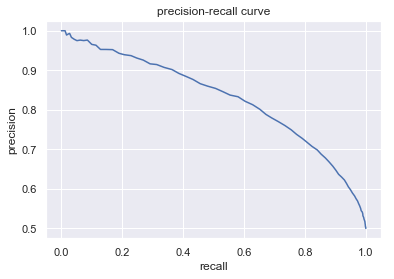

In [117]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

k = 5 #分割数
features = spar.load_npz('data/features.npz')
porality = np.load('data/polarity.npy')
n = len(porality)

partition = [int(m * n/k) for m in range(k+1)]
section = [(start, end) for start, end in zip(partition[:k], partition[1:])]

tests = [
    ('precision', precision_score, []),
    ('recall', recall_score, []),
]

# 文章がpositiveであると予測される確率を計算する
probability = np.empty(n)
for start, end in section:
    fancy_idx = np.array([True if start <= i < end else False for i in range(n)],dtype=bool)
    # 検証用データ
    va_por, va_fs = porality[fancy_idx], features[fancy_idx]
    # 学習用データ
    tr_por, tr_fs = porality[np.logical_not(fancy_idx)], features[np.logical_not(fancy_idx)]
    
    model = LogisticRegression(solver='lbfgs')
    model.fit(tr_fs, tr_por)
    probability[start:end] = model.predict_proba(va_fs)[:,1]

# 確率が閾値以上ならpositiveと判定する
for threshold in np.linspace(0,max(probability),100):
    for name, test, results in tests:
        predict = np.where(probability >= threshold, 1, -1)
        results.append(test(porality, predict))
        
precision, recall = [results for _, _, results in tests]
plt.plot(recall, precision)
plt.title('precision-recall curve')
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()